In [1]:
!pip install peptdeep

# Library import

In [ ]:
from peptdeep.pretrained_models import ModelManager
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

import sys

# from google.colab import drive # delete this line if not used on colab
# drive.mount("/content/drive", force_remount = True) # delete this line if not used on colab

# sys.path.append("C:/Users/Walraff/OneDrive - Universite de Liege/Documents/Ulg/Master2/TFE/")
# sys.path.append("/content/drive/MyDrive/TFE/")
import utils

import wandb

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

2025-05-01 11:29:12> Downloading https://github.com/MannLabs/alphapeptdeep/releases/download/pre-trained-models/pretrained_models.zip ...
2025-05-01 11:29:17> The pretrained models had been downloaded in /root/peptdeep/pretrained_models/pretrained_models.zip
Mounted at /content/drive


In [4]:
# data_path = "C:/Users/Walraff/OneDrive - Universite de Liege/Documents/Ulg/Master2/TFE/data"
data_path = "/content/drive/MyDrive/TFE/"
original_df = pd.read_csv(f'{data_path}/final_status_SPARE.csv')
original_df

,ProteinName_SPARE,Peptide_SPARE,Status_SPARE
0,sp|P02751|FINC_HUMAN,VDVIPVNLPGEHGQR,bon
1,sp|P02751|FINC_HUMAN,STTPDITGYR,bon
2,sp|P02751|FINC_HUMAN,SYTITGLQPGTDYK,bon
3,sp|P02751|FINC_HUMAN,IYLYTLNDNAR,bon
4,sp|P04114|APOB_HUMAN,TGISPLALIK,bon
...,...,...,...
150,sp|P02743|SAMP_HUMAN,VGEYSLYIGR,bon
151,sp|P04004|VTNC_HUMAN,GQYCYELDEK,mauvais
152,sp|P04004|VTNC_HUMAN,FEDGVLDPDYPR,bon
153,sp|P04004|VTNC_HUMAN,DWHGVPGQVDAAMAGR,bon


# Dataset, model and loading data

In [ ]:
# Creating a dataframe with the sequences and labels
df = pd.DataFrame()
df["sequence"] = original_df["Peptide_SPARE"]
# column required for CCS model
df["mods"] = ''
df["mod_sites"] = ''
df["nAA"] = df["sequence"].str.len()
df["charge"] = 0

df["quantotypic"] = original_df.apply(lambda row: 0 if row['Status_SPARE'] == 'bon' else 1, axis=1)

class_counts = df['quantotypic'].value_counts()
num_pos = class_counts.get(1, 0)  # Nombre d'échantillons de la classe 1
num_neg = class_counts.get(0, 0)  # Nombre d'échantillons de la classe 0

pos_weight = torch.tensor(num_neg / num_pos, dtype=torch.float64)

print("Class counts:\n", class_counts)
print("Pos weight (for class 1):", pos_weight)

Class counts:
 quantotypic
0    117
1     38
Name: count, dtype: int64
Pos weight (for class 1): tensor(3.0789, dtype=torch.float64)


In [6]:
data_human_unique_peptide_path = f'{data_path}/Tryptic unique peptide of the human proteome.csv'
data_human_unique_peptide = pd.read_csv(data_human_unique_peptide_path, delimiter = ";")
data_human_unique_peptide

,Peptide,Protein,Peptide Modified Sequence,Standard Type,First Position,Last Position,Missed Cleavages,Predicted Retention Time,Average Measured Retention Time,Peptide Note
0,MQLVQESEEK,sp|A0A0B4J2F0|PIOS1_HUMAN,MQLVQESEEK,NaN,43,52,0,NaN,NaN,NaN
1,QPCLPIWHEMVETGGSEGVVR,sp|A0A0K2S4Q6|CD3CH_HUMAN,QPC[+57]LPIWHEMVETGGSEGVVR,NaN,59,79,0,NaN,NaN,NaN
2,VPLLLSILGAILWVNRPWR,sp|A0A0K2S4Q6|CD3CH_HUMAN,VPLLLSILGAILWVNRPWR,NaN,177,195,0,NaN,NaN,NaN
3,SHPPPPEK,sp|A0A0U1RRE5|NBDY_HUMAN,SHPPPPEK,NaN,61,68,0,NaN,NaN,NaN
4,SVSLLRPPFSQLPSK,sp|A0A1B0GTW7|CIROP_HUMAN,SVSLLRPPFSQLPSK,NaN,31,45,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
365085,ELNQYFELAK,sp|Q9Y3F1|TA6P_HUMAN,ELNQYFELAK,NaN,44,53,0,NaN,NaN,NaN
365086,GSFLIWLLLCWNSWYHLR,sp|Q9Y6C7|L3R2A_HUMAN,GSFLIWLLLC[+57]WNSWYHLR,NaN,36,53,0,NaN,NaN,NaN
365087,LCHGDSELTSGLLAT,sp|Q9Y6C7|L3R2A_HUMAN,LC[+57]HGDSELTSGLLAT,NaN,80,94,0,NaN,NaN,NaN
365088,SCQIEQVK,sp|Q9Y6Z2|CF123_HUMAN,SC[+57]QIEQVK,NaN,32,39,0,NaN,NaN,NaN


In [7]:
unique_peptide = data_human_unique_peptide["Peptide"]
filtering_self_training = unique_peptide.apply(len) <= max_len
unique_peptide = unique_peptide[filtering_self_training].reset_index(drop=True)
unique_peptide = unique_peptide.drop_duplicates(ignore_index = True)
unique_peptide

,Peptide
0,MQLVQESEEK
1,QPCLPIWHEMVETGGSEGVVR
2,VPLLLSILGAILWVNRPWR
3,SHPPPPEK
4,SVSLLRPPFSQLPSK
...,...
331077,ELNQYFELAK
331078,GSFLIWLLLCWNSWYHLR
331079,LCHGDSELTSGLLAT
331080,SCQIEQVK


In [ ]:
class CCSPeptideDataset(Dataset):
    """
    Custom Dataset for CCS peptide models.

    This dataset stores precomputed amino acid index features, modification features,
    and corresponding labels for each peptide.

    Args:
        aa_indices (list or torch.Tensor): Encoded amino acid sequences.
        mod_x (list or torch.Tensor): Additional modification or structure-related features.
        labels (list or torch.Tensor): Labels associated with each peptide sample.
    """
    def __init__(self, aa_indices, mod_x, labels):
        self.aa_indices = aa_indices
        self.mod_x = mod_x
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.aa_indices[idx], self.mod_x[idx], self.labels[idx]

In [ ]:
class CCSPeptideModel(nn.Module):
    """
    Model using CCS encoder and MLP classifier.

    Args:
        encoder (nn.Module): Encoder module that takes (aa_indices, mod_x, charge) as input.
        hidden_dim (int): Dimension of the first hidden layer in the classifier.
        dropout_prob (float): Dropout probability applied after each hidden layer.
        num_layers (int): Number of hidden layers before the final regression output layer.
    """
    def __init__(self, encoder, hidden_dim, dropout_prob, num_layers):
        super(CCSPeptideModel, self).__init__()
        self.encoder = encoder  # L'encoder est maintenant directement utilisé

        layers = []
        input_dim = 256
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
            input_dim = hidden_dim
            hidden_dim = max(hidden_dim // 2, 1)  # Assurer une réduction progressive

        layers.append(nn.Linear(input_dim, 1))  # Couche finale

        self.classifier = nn.Sequential(*layers)

    def forward(self, aa_indices, mod_x):
        charges = torch.zeros(aa_indices.shape[0], 1, dtype=torch.float32)
        charges = charges.to(aa_indices.device)
        X = self.encoder(aa_indices, mod_x, charges)
        X = self.classifier(X)
        return X

In [10]:
model_mgr = ModelManager()
model_mgr.load_installed_models()
pretrained_model = model_mgr.ccs_model

# Functions

In [ ]:
def precompute_features(df, pretrained_model, model_name='CCS'):
    """
    Precomputes peptide features (`aa_indices`, `mod_x`, and `labels`) to accelerate training.

    Args:
        df (pd.DataFrame): DataFrame containing peptide sequences and labels.
        pretrained_model (nn.Module): Pretrained model with methods to extract amino acid and modification features.
        model_name (str, optional): Identifier for model-specific preprocessing logic (e.g., 'CCS', 'RT').

    Returns:
        tuple: Three lists:
            - aa_indices_list (list of torch.Tensor): Encoded amino acid index features.
            - mod_x_list (list of torch.Tensor): Additional modification features.
            - labels_list (list of torch.Tensor): Corresponding labels as float tensors.
    """
    aa_indices_list = []
    mod_x_list = []
    labels_list = []

    for _, row in tqdm(df.iterrows(), desc="Precompute Feature"):
        sequence = row["sequence"]
        label = row["quantotypic"]

        row_df = pd.DataFrame({"sequence": [sequence]})
        row_df["nAA"] = row_df["sequence"].str.len()
        row_df["mod_sites"] = ""
        row_df["mods"] = ""

        if model_name == 'CCS':
            row_df["charge"] = 0 # Required for CCS input

        # Extract features using the pretrained model
        aa_indices = pretrained_model._get_26aa_indice_features(row_df).squeeze(0)
        mod_x = pretrained_model._get_mod_features(row_df).squeeze(0)

        # Store computed features
        aa_indices_list.append(aa_indices)
        mod_x_list.append(mod_x)
        labels_list.append(torch.tensor(label, dtype=torch.float32))

    return aa_indices_list, mod_x_list, labels_list

def collate_batch(batch):
    """
    Custom collate function to dynamically pad amino acid and modification feature sequences.
    
    Args:
        batch (list of tuples): Each element is a tuple (aa_indices, mod_x, y).

    Returns:
        tuple:
            - aa_indices_padded (torch.Tensor): Padded tensor of amino acid index sequences (batch_size, max_len).
            - mod_x_padded (torch.Tensor): Padded tensor of modification features (batch_size, max_len, feature_dim).
            - y_tensor (torch.Tensor): Tensor of labels (batch_size,).
    """
    aa_indices_list, mod_x_list, y_list = zip(*batch)

    # Pad variable-length amino acid index sequences
    aa_indices_padded = pad_sequence(aa_indices_list, batch_first=True, padding_value=0)

    # Pad variable-length modification feature vectors
    mod_x_padded = pad_sequence(mod_x_list, batch_first=True, padding_value=0)

    # Convert labels to tensor
    y_tensor = torch.tensor(y_list, dtype=torch.float32)

    return aa_indices_padded, mod_x_padded, y_tensor

In [ ]:
# Initialize the CCS transfer learning model with a pretrained encoder
model = CCSPeptideModel(pretrained_model.model.ccs_encoder, hidden_dim=128, dropout_prob=0.5, num_layers=2)

# Select the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model and its encoder to the selected device
model.to(device)
model.encoder.to(device)

# Precompute input features (aa_indices, mod_x, labels) from the input DataFrame
aa_indices_list, mod_x_list, labels_list = precompute_features(df, pretrained_model)

# Create the dataset using the precomputed features
dataset = CCSPeptideDataset(aa_indices_list, mod_x_list, labels_list)

# Create the DataLoader with dynamic padding using a custom collate function
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

# Example loop to inspect a single batch
for batch in train_loader:
    aa_idx, mod_x, y = batch

    # Move batch data to the selected device
    aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)

    # Print the input and output for inspection
    print(aa_idx)              # Amino acid indices (padded)
    print(mod_x)               # Modification feature matrix (padded)
    print(y)                   # Labels
    print(model(aa_idx, mod_x))  # Model predictions
    break


Precompute Feature: 155it [00:00, 464.37it/s]


tensor([[ 0,  4,  7, 25, 12,  6, 17, 12, 12, 18,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0,  5, 19,  4, 20, 19, 25, 22, 19, 12, 11,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0, 22,  4, 22,  9, 16, 22, 14, 12, 16,  7,  5,  8,  7, 17, 18,  0,  0,
          0,  0,  0,  0,  0],
        [ 0,  4, 19, 16, 22, 12,  9,  4,  6,  6,  5,  4, 20,  5, 18,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0, 12, 22, 25, 16, 19,  3,  5,  5, 11,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0, 20, 22, 17,  1, 22, 12, 20, 22, 16, 11,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0,  7,  1, 25, 16, 12, 19,  9,  5, 16,  9,  7, 22, 18,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 0,  3, 19, 25, 20,  5,  4,  1, 17,  3,  9,  4,  7, 20,  9,  5, 22, 16,
         11,  0,  0,  0,  0],
        [ 0,  6,  5,  4,  7, 22, 12,  4, 16,  4, 25, 16, 18,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
 

In [ ]:
def early_stopping(val_losses, patience):
    """
    Checks if the last 'patience' validation losses have increased or remained the same.

    Args:
        val_losses (list): List of validation losses.
        patience (int): Number of consecutive epochs to check for lack of improvement.

    Returns:
        bool: True if the last 'patience' losses show no improvement, otherwise False.
    """
    # Not enough values to apply the early stopping criterion
    if len(val_losses) < patience + 1:
        return False

    # Check if each of the last 'patience' losses is greater than or equal to the previous one
    for i in range(-patience, -1):
        if val_losses[i] < val_losses[i + 1]:
            continue
        else:
            return False

    return True

In [ ]:
def reordering(data, labels, batch_converter, device):
    """
    Prepares and converts a batch of sequence data and labels for ESM-2 model input.

    Args:
        data (tuple): Tuple containing two lists (e.g., sequence names and sequences).
        labels (torch.Tensor): Tensor of labels associated with each sequence.
        batch_converter (callable): Function to convert (name, sequence) pairs into tokenized format.
        device (torch.device): Device to move the tensors to (e.g., 'cuda' or 'cpu').

    Returns:
        tuple:
            - batch_tokens (torch.Tensor): Tensor of tokenized sequences.
            - batch_labels (torch.Tensor): Tensor of corresponding labels (shape: [batch_size]).
    """
    # Reformat data into a list of (name, sequence) tuples
    ReArrangeData = []
    for i in range(len(data[0])):
        ReArrangeData.append((data[0][i], data[1][i]))

    # Move labels to device and ensure float format
    labels = labels.float()
    batch_labels = labels.to(device).unsqueeze(1)

    # Convert sequences to tokens using the batch converter
    batch_tokens = batch_converter(ReArrangeData)[2].to(device)

    return batch_tokens, batch_labels.squeeze(1)

def train_epoch(model, dataloader, optimizer, criterion, device, model_name='Scratch', batch_converter=None):
    """
    Trains the model for a single epoch.

    Args:
        model (nn.Module): The model to train.
        dataloader (DataLoader): DataLoader providing training data batches.
        optimizer (torch.optim.Optimizer): Optimizer used for updating model weights.
        criterion (nn.Module): Loss function to compute the training loss.
        device (str or torch.device): Device on which computations are performed ('cuda' or 'cpu').
        model_name (str): Specifies the model type (e.g., 'Scratch', 'ESM', 'RT', 'CCS').
        batch_converter (callable, optional): Function used to convert ESM data batches.

    Returns:
        float: Mean training loss over the entire epoch.
    """
    model.train()
    train_losses = []

    for batch in dataloader:
        # Prepare inputs and targets based on the model type
        if model_name == 'ESM':
            X, y = batch
            X, y = reordering(X, y, batch_converter, device)
        elif model_name in ['RT', 'CCS']:
            aa_idx, mod_x, y = batch
            aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
        else:
            X, y = batch
            X, y = X.to(device), y.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        if model_name in ['RT', 'CCS']:
            output = model(aa_idx, mod_x).squeeze(1)
        else:
            output = model(X).squeeze(1)

        # Compute loss
        loss = criterion(output, y)

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Record the loss
        train_losses.append(loss.item())
    
    # wandb.log({"training_loss": np.array(train_losses).mean()})

    return np.mean(train_losses)

def val_epoch(model, dataloader, criterion, device, threshold=0.5, model_name='Scratch', batch_converter=None):
    """
    Validates the model for one epoch and computes evaluation metrics.

    Args:
        model (nn.Module): The model to evaluate.
        dataloader (DataLoader): DataLoader providing validation data.
        criterion (nn.Module): Loss function used for evaluation.
        device (str or torch.device): Device on which computations are performed ('cuda' or 'cpu').
        threshold (float, optional): Threshold for binary classification (applied to predicted probabilities). Defaults to 0.5.
        model_name (str): Model type identifier (e.g., 'Scratch', 'ESM', 'RT', 'CCS').
        batch_converter (callable, optional): Function for converting ESM batches into tokenized format.

    Returns:
        dict: Dictionary containing the following metrics:
              - "loss": Mean validation loss.
              - "accuracy": Classification accuracy.
              - "roc_auc": Area under the ROC curve.
              - "pr_auc": Area under the precision-recall curve.
    """
    model.eval()
    val_losses = []
    all_targets = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            # Prepare inputs and targets based on model type
            if model_name == 'ESM':
                X, y = batch
                X, y = reordering(X, y, batch_converter, device)
            elif model_name in ['RT', 'CCS']:
                aa_idx, mod_x, y = batch
                aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
            else:
                X, y = batch
                X, y = X.to(device), y.to(device)

            # Forward pass
            if model_name in ['RT', 'CCS']:
                output = model(aa_idx, mod_x).squeeze(1)
            else:
                output = model(X).squeeze(1)

            probabilities = torch.sigmoid(output)  # Convert logits to probabilities
            loss = criterion(output, y)
            val_losses.append(loss.item())

            # Threshold probabilities to get binary predictions
            binary_output = (probabilities >= threshold).float()

            # Store results
            all_targets.extend(y.cpu().numpy())
            all_predictions.extend(binary_output.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Compute average loss and metrics
    mean_loss = np.mean(val_losses)
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    roc_auc = roc_auc_score(all_targets, all_probabilities) if len(np.unique(all_targets)) > 1 else 0.0
    pr_auc = average_precision_score(all_targets, all_probabilities) if len(np.unique(all_targets)) > 1 else 0.0

    # Log metrics with wandb
    # wandb.log({
    #     "validation_loss": mean_loss,
    #     "validation_accuracy": accuracy,
    #     "validation_roc_auc": roc_auc,
    #     "validation_pr_auc": pr_auc,
    # })

    return {
        "loss": mean_loss,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

In [ ]:
def train(model, train_loader, val_loader, n_epochs, lr, threshold=0.5, do_early_stopping=True, model_name='Scratch', batch_converter=None, weight=None, verbose=False):
    """
    Trains the model over multiple epochs with validation after each epoch.

    Args:
        model (nn.Module): The model instance to train.
        train_loader (DataLoader): DataLoader providing training data.
        val_loader (DataLoader): DataLoader providing validation data.
        n_epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.
        filename (str): File name to save the final model.
        threshold (float, optional): Threshold for binary classification. Defaults to 0.5.
        do_early_stopping (bool, optional): Whether to apply early stopping. Defaults to True.
        model_name (str, optional): Identifier for model type (e.g., 'Scratch', 'ESM', 'RT', 'CCS').
        batch_converter (callable, optional): Function to convert ESM batches into token format.
        weight (torch.Tensor, optional): Weight for positive class in BCEWithLogitsLoss.
        verbose (bool, optional): If True, prints training progress. Defaults to False.

    Returns:
        dict: Training history containing:
            - "train_loss": List of training losses per epoch.
            - "val_loss": List of validation losses per epoch.
            - "val_accuracy": List of validation accuracies.
            - "val_roc_auc": List of ROC-AUC scores.
            - "val_pr_auc": List of PR-AUC scores.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.cuda.empty_cache()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_roc_auc": [],
        "val_pr_auc": [],
    }

    for epoch in range(n_epochs):
        if verbose:
            print(f"\n--- Epoch {epoch + 1}/{n_epochs} ---")

        # Train for one epoch
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, model_name=model_name, batch_converter=batch_converter)

        # Validate after each epoch
        val_metrics = val_epoch(model, val_loader, criterion, device, threshold, model_name=model_name, batch_converter=batch_converter)

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_accuracy"].append(val_metrics["accuracy"])
        history["val_roc_auc"].append(val_metrics["roc_auc"])
        history["val_pr_auc"].append(val_metrics["pr_auc"])

        # Early stopping
        if early_stopping(history["val_loss"], patience=5) and do_early_stopping:
            print(f"Early stopping triggered at {epoch} epoch.")
            break

    # wandb.log({"Early_stopping": epoch})

    return history

In [ ]:
def compute_pos_weight(df, target_column):
    """
    Computes the pos_weight value for BCEWithLogitsLoss based on class imbalance.

    Args:
        df (pd.DataFrame): DataFrame containing the target labels.
        target_column (str): Name of the column with binary class labels.

    Returns:
        torch.Tensor: A tensor representing the positive class weight for use in BCEWithLogitsLoss.
                      If no positive samples are found, defaults to a weight of 1.0.
    """
    class_counts = df[target_column].value_counts()

    num_pos = class_counts.get(1, 0)  # Number of positive samples
    num_neg = class_counts.get(0, 0)  # Number of negative samples

    if num_pos == 0:
        pos_weight = torch.tensor(1.0, dtype=torch.float64)
    else:
        pos_weight = torch.tensor(num_neg / num_pos, dtype=torch.float64)

    return pos_weight

compute_pos_weight(df, 'quantotypic')

tensor(3.0789, dtype=torch.float64)

In [ ]:
def compute_best(history, best_history, model, best_model):
    """
    Compares the current model to the best model so far based on validation PR AUC,
    and updates the best model and history if the current model performs better.

    Args:
        history (dict): Dictionary containing the current training and validation metrics.
        best_history (dict): Dictionary containing the best validation metrics so far.
        model (nn.Module): Current model instance.
        best_model (nn.Module): Best model instance so far.

    Returns:
        tuple: Updated best model and its corresponding history.
    """
    if best_history is None or (history["val_pr_auc"][-1] > best_history["val_pr_auc"][-1]):
        best_model = model
        best_history = history

    return best_model, best_history

def evaluate_ccs_model(model, test_df):
    """
    Evaluates a trained CCS model on the test dataset and returns classification metrics.

    Args:
        model (nn.Module): Trained CCS model.
        test_df (pd.DataFrame): Test data containing peptide sequences and labels.

    Returns:
        dict: Dictionary containing evaluation metrics:
              - 'accuracy': Classification accuracy.
              - 'precision': Precision score.
              - 'recall': Recall score.
              - 'f1': F1 score.
              - 'roc_auc': ROC AUC score.
              - 'pr_auc': Precision-Recall AUC score.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu" # Get the device
    model.eval()
    model.to(device) # Move the model to the device
    model_mgr = ModelManager()
    model_mgr.load_installed_models()
    pretrained_model = model_mgr.rt_model

    test_aa_indices, test_mod_x, test_labels = precompute_features(test_df, pretrained_model)
    test_dataset = CCSPeptideDataset(test_aa_indices, test_mod_x, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for aa_indices, mod_x, labels in test_loader: # Unpack all three values
            aa_indices, mod_x, labels = aa_indices.to(device), mod_x.to(device), labels.to(device) # Move data to the device
            outputs = model(aa_indices, mod_x) # Pass both aa_indices and mod_x to the model
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets)

    predicted_classes = (all_preds >= 0.5).astype(int)

    accuracy = accuracy_score(all_targets, predicted_classes)
    precision = precision_score(all_targets, predicted_classes)
    recall = recall_score(all_targets, predicted_classes)
    f1 = f1_score(all_targets, predicted_classes)
    roc_auc = roc_auc_score(all_targets, all_preds)
    pr_auc = average_precision_score(all_targets, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

def write_into_json(dict, filename):
    import json
    with open(filename, 'w') as f:
        json.dump(dict, f)

In [ ]:
def normalized_entropy(p, batch=True):
    """
    Computes the normalized entropy of binary probabilities.

    Args:
        p (array-like or torch.Tensor): Probabilities (between 0 and 1). Can be a single value, 
                                        a numpy array, or a PyTorch tensor.
        batch (bool, optional): If True, treats p as a batch of PyTorch tensors and returns
                                entropy for each element. If False, treats p as a numpy array
                                or scalar. Defaults to True.

    Returns:
        np.ndarray or torch.Tensor: Normalized entropy values.
    """
    eps = 1e-8
    if batch:
        # Convert to tensor if not already
        if not isinstance(p, torch.Tensor):
            p = torch.tensor(p)
        p = torch.clamp(p, eps, 1 - eps)
        # Ensure shape [B, 1] for batch processing
        if p.dim() == 1:
            p = p.unsqueeze(1)

        # Create two class distributions
        dist = torch.cat([p, 1-p], dim=1)  # forme [B, 2]
        entropy = -(dist * torch.log(dist)).sum(dim=1)
        norm_entropy = entropy / torch.log(torch.tensor(2.0))
    else:
        # numpy-based computation for single values or arrays
        p = np.array(p, dtype=float)
        p = np.clip(p, eps, 1 - eps)
        entropy = -(p * np.log(p) + (1-p) * np.log(1-p))
        norm_entropy = entropy / np.log(2)

    return norm_entropy


def find_optimal_probability_threshold(model, val_loader, device='cpu', method='roc', model_name="Scratch"):
    """
    Finds the optimal decision threshold for classification based on ROC or PR curve distance.

    The function evaluates model predictions on the validation set and searches for the threshold
    that minimizes the distance to the ideal point of the ROC curve (FPR=0, TPR=1) or PR curve (precision=1, recall=1).

    Args:
        model (nn.Module): Trained model to evaluate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        device (str or torch.device, optional): Device to run computations ('cpu' or 'cuda'). Defaults to 'cpu'.
        method (str, optional): Criterion for threshold selection ('roc' or 'pr'). Defaults to 'roc'.
        model_name (str, optional): Type of model ('Scratch', 'RT', 'CCS', etc.). Defaults to 'Scratch'.

    Returns:
        float: The optimal threshold value between 0.5 and 1.0.
    """
    print(method)
    model.eval()

    all_confidences = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            if model_name in ['RT', 'CCS']:
                aa_idx, mod_x, y_val = batch
                aa_idx, mod_x, y_val = aa_idx.to(device), mod_x.to(device), y_val.to(device)
                logits = model(aa_idx, mod_x).squeeze(1)
            else:
                X_val, y_val = batch
                X_val, y_val = X_val.to(device), y_val.to(device)
                logits = model(X_val)

            probabilities = torch.sigmoid(logits)

            if model_name == 'CCS':
                preds = (probabilities > 0.5).long()
                confidence = torch.where(preds == 1, probabilities, 1 - probabilities)
            else:
                preds = (probabilities > 0.5).long().squeeze(1)
                confidence = torch.where(preds == 1, probabilities, 1 - probabilities).squeeze(1)

            all_confidences.append(confidence.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(y_val.cpu())

    # Concatenate results
    all_confidences = torch.cat(all_confidences, dim=0).numpy()
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    # Determine which predictions were correct
    actually_positive = (all_preds == all_labels)

    thresholds = np.linspace(0.5, 1, 500)
    best_thr = 0.0
    best_dist = float('inf')

    for thr in thresholds:
        accepted_mask = (all_confidences > thr)

        TP = np.logical_and(accepted_mask, actually_positive).sum()
        FP = np.logical_and(accepted_mask, ~actually_positive).sum()
        FN = np.logical_and(~accepted_mask, actually_positive).sum()

        P = actually_positive.sum()
        N = len(actually_positive) - P

        TPR = TP / (P + 1e-8)  # Sensitivity
        FPR = FP / (N + 1e-8)
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)

        if method == 'pr':
            dist = np.sqrt((1 - precision)**2 + (1 - recall)**2)
        else:
            dist = np.sqrt((FPR - 0)**2 + (TPR - 1)**2)

        if dist < best_dist:
            best_dist = dist
            best_thr = thr

    return best_thr

In [ ]:
def generate_pseudo_labels(probabilities, method, value=0.5):
    """
    Generates pseudo-labels for self-training based on model probabilities.

    Args:
        probabilities (array-like): Array of predicted probabilities for the positive class.
        method (str): Pseudo-labeling method to use ("fixed", "optimal", or "TopK").
        value (float, optional): Threshold value for "fixed"/"optimal" or proportion for "TopK". Defaults to 0.5.

    Returns:
        tuple:
            - class1 (np.ndarray of bool): Mask for examples labeled as class 1.
            - class0 (np.ndarray of bool): Mask for examples labeled as class 0.
    """
    probabilities = np.array(probabilities)

    if method == "fixed" or "optimal" in method:
        other_threshold = 1 - value
        class1 = probabilities > value
        class0 = probabilities < other_threshold
    elif "TopK" in method:
        K = int(value * len(probabilities))

        indices_sorted = np.argsort(probabilities)

        class1 = np.zeros_like(probabilities, dtype=bool)
        class0 = np.zeros_like(probabilities, dtype=bool)

        # Assign bottom K to class 0
        class0[indices_sorted[:K]] = True

        # Assign top K to class 1
        class1[indices_sorted[-K:]] = True

    return class1, class0

def plot_probabilities(output_proba, path, zoomin=False):
    """
    Plots a histogram of model output probabilities and optionally zooms in on specific ranges.

    Args:
        output_proba (array-like): Array of output probabilities (between 0 and 1).
        path (str): File path to save the main histogram plot (PNG format).
        zoomin (bool, optional): If True, also generate and save zoomed-in histograms.
                                 Defaults to False.

    Returns:
        None: Plots are saved as image files and displayed.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(output_proba, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
    plt.xlabel("Output probabilities")
    plt.ylabel("Frequency")
    plt.title("Histogram of output probabilities")
    plt.savefig(path)
    plt.show()
    plt.close()

    if zoomin:
        # Zoom on [0, 0.1]
        plt.figure(figsize=(8, 6))
        plt.hist(output_proba, bins=np.linspace(0, 0.1, 21), edgecolor='black', alpha=0.7)
        plt.xlabel("Output probabilities (zoom [0, 0.1])")
        plt.ylabel("Frequency")
        plt.title("Zoomed histogram [0, 0.1]")

        zoom_path_1 = path.replace(".png", "_zoomin01.png")

        plt.savefig(zoom_path_1)
        plt.show()
        plt.close()

        # Zoom on [0.9, 1.0]
        plt.figure(figsize=(8, 6))
        plt.hist(output_proba, bins=np.linspace(0.9, 1.0, 21), edgecolor='black', alpha=0.7)
        plt.xlabel("Output probabilities (zoom [0.9, 1.0])")
        plt.ylabel("Frequency")
        plt.title("Zoomed histogram [0.9, 1.0]")

        zoom_path_2 = path.replace(".png", "_zoomin09.png")

        plt.savefig(zoom_path_2)
        plt.show()
        plt.close()

def plot_pl_instances(pseudo_label_instance_list, path):
    """
    Plots the number of new pseudo-labeled instances per iteration during pseudo-labeling.

    Args:
        pseudo_label_instance_list (list of tuples): List where each element is a tuple (class0_count, class1_count)
                                                     representing the number of new pseudo-labeled samples for each class.
        path (str): Path (without extension) to save the plot as a PNG file.

    Returns:
        None: The plot is saved to the specified path and closed.
    """
    plt.figure(figsize=(8, 6))

    iterations = range(len(pseudo_label_instance_list))
    class0 = [pl[0] for pl in pseudo_label_instance_list]
    class1 = [pl[1] for pl in pseudo_label_instance_list]

    plt.bar(iterations, class0, color='blue', label='Quantotypic')
    plt.bar(iterations, class1, bottom=class1, color='orange', label='Non-Quantotypic')

    plt.xlabel("Iteration")
    plt.ylabel("Number of new pseudo-labeled instances")
    plt.title("Number of new pseudo-labeled instances per iteration")
    plt.legend()
    plt.savefig(f"{path}.png")
    plt.close()

def plot_metric_evolutions(evolutions):
    """
    Plots the evolution of various metrics over iterations.

    Args:
        evolutions (dict): Dictionary where keys are metric names and values are lists of metric values over iterations.

    Returns:
        None: The plot is displayed.
    """
    plt.figure()

    for metric, evo_list in evolutions.items():
        plt.plot(evo_list, label=metric)

    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [ ]:
def find_ccs_param(models_path="/content/drive/MyDrive/TFE/Models"):
    """
    Tries different hyperparameter combinations to load a CCS model from a saved state dictionary.

    Args:
        models_path (str, optional): Path to the saved model state_dict file. 
                                     Defaults to "/content/drive/MyDrive/TFE/Models".

    Returns:
        tuple or None: Tuple (dropout, n_layers, hidden_size, embedding_size) if a model is successfully loaded,
                       otherwise None if no configuration works.
    """
    for dropout in [0.2, 0.3]:
        for n_layers in [1, 2, 3]:
            for hidden_size, embedding_size in [(64, 64), (128, 128)]:
                try:
                    model_mgr = ModelManager()
                    pretrained_model = model_mgr.ccs_model
                    model = CCSPeptideModel(
                        pretrained_model.model.ccs_encoder,
                        dropout_prob=dropout,
                        num_layers=n_layers,
                        hidden_dim=hidden_size
                    )
                    # Attempt to load model weights
                    model.load_state_dict(torch.load(models_path))
                    # If successful, return configuration
                    return dropout, n_layers, hidden_size, embedding_size
                except Exception as e:
                    print(
                        f"Error for config dropout={dropout}, "
                        f"n_layers={n_layers}, hidden_size={hidden_size}, "
                        f"embedding_size={embedding_size}"
                    )
    return None

# Plot outputs probabilities from the supervised learning model

Fold 1 on 5
model filename: Best_CCS_NES_FT_N_cvfold1


Precompute Feature: 99it [00:00, 438.81it/s]
Precompute Feature: 25it [00:00, 491.11it/s]


331082
330929


Precompute Feature: 330929it [13:14, 416.68it/s]


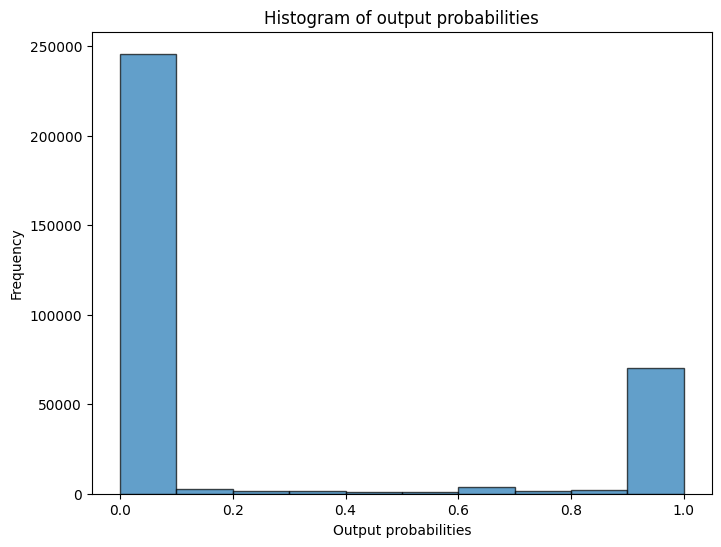

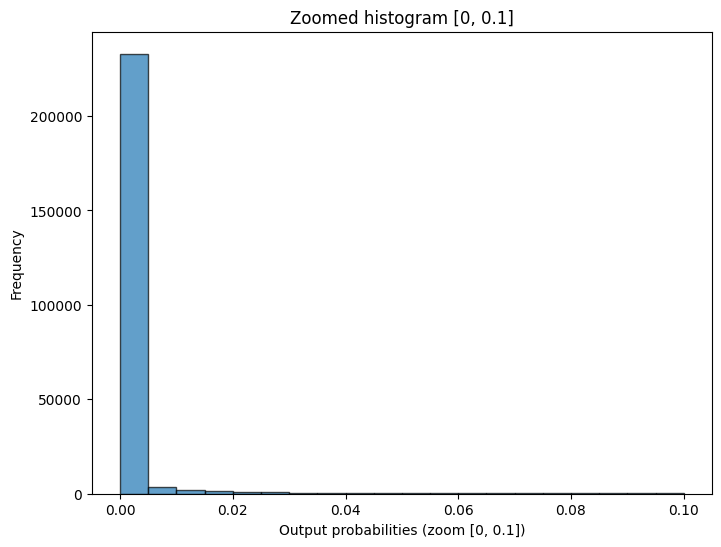

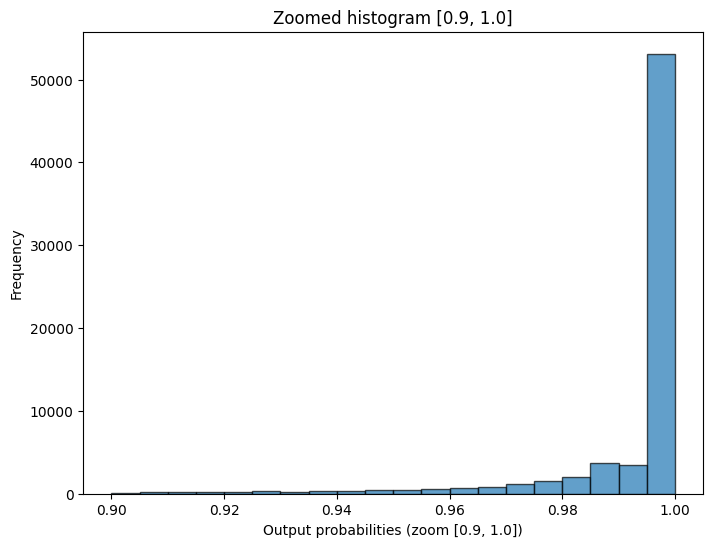

Fold 2 on 5
model filename: Best_CCS_NES_FT_N_cvfold2
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128


Precompute Feature: 99it [00:00, 443.59it/s]
Precompute Feature: 25it [00:00, 437.50it/s]


331082
330929


Precompute Feature: 330929it [13:07, 420.46it/s]


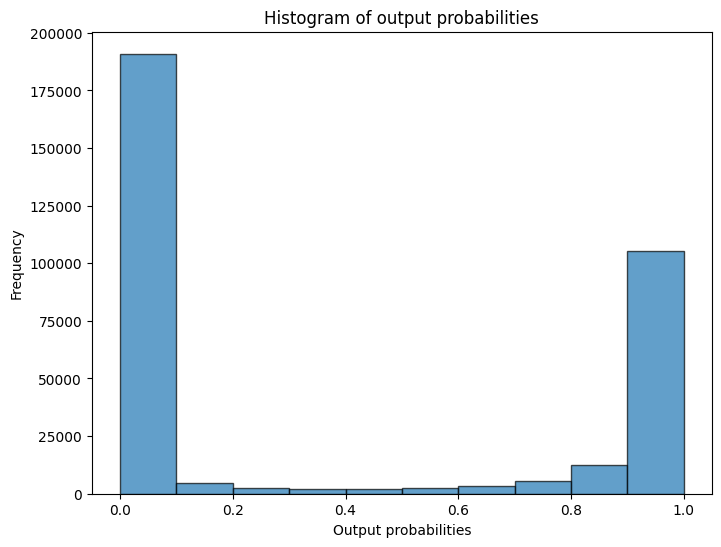

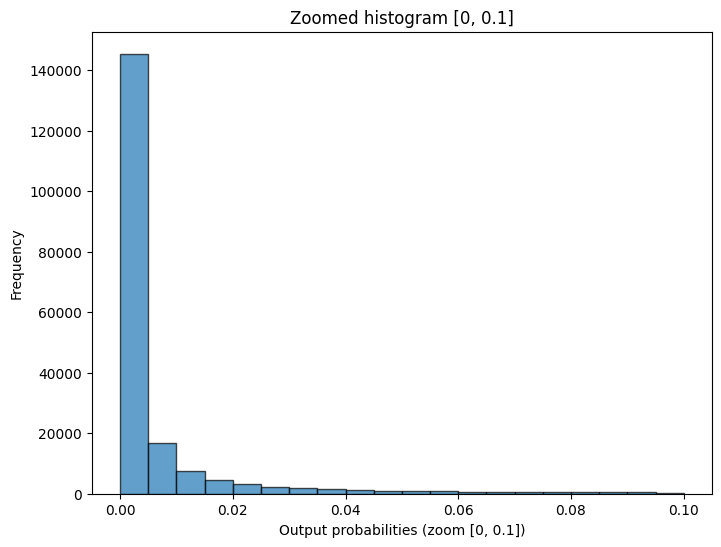

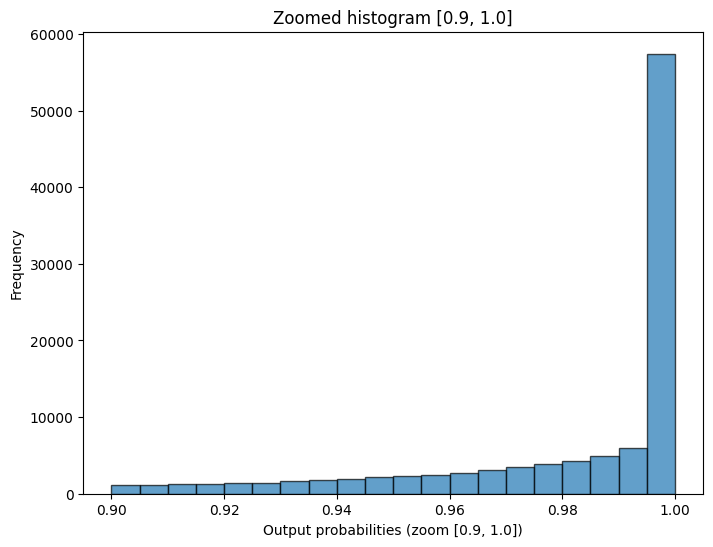

Fold 3 on 5
model filename: Best_CCS_NES_FT_N_cvfold3
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128


Precompute Feature: 99it [00:00, 438.83it/s]
Precompute Feature: 25it [00:00, 436.57it/s]


331082
330929


Precompute Feature: 330929it [13:07, 419.99it/s]


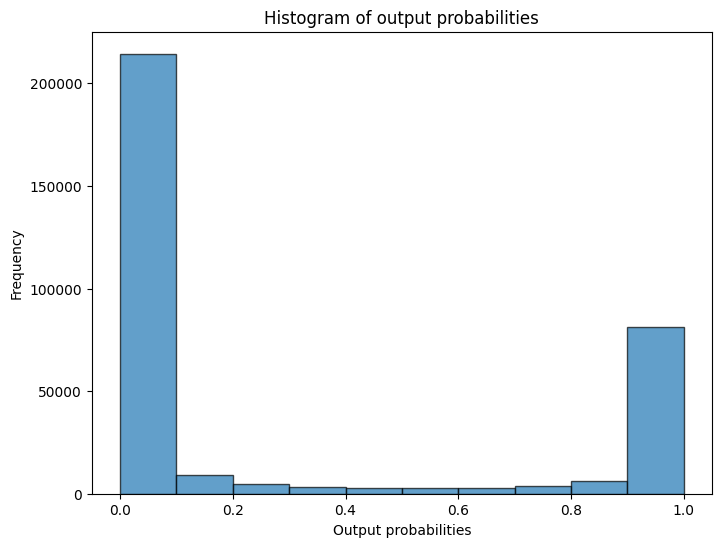

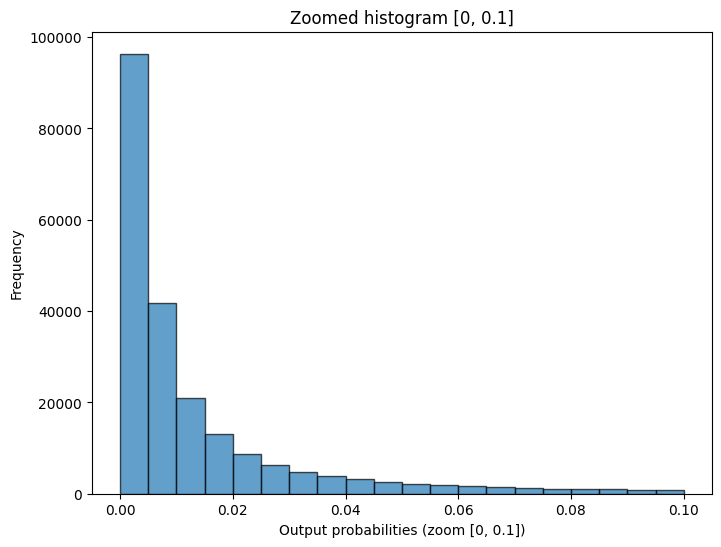

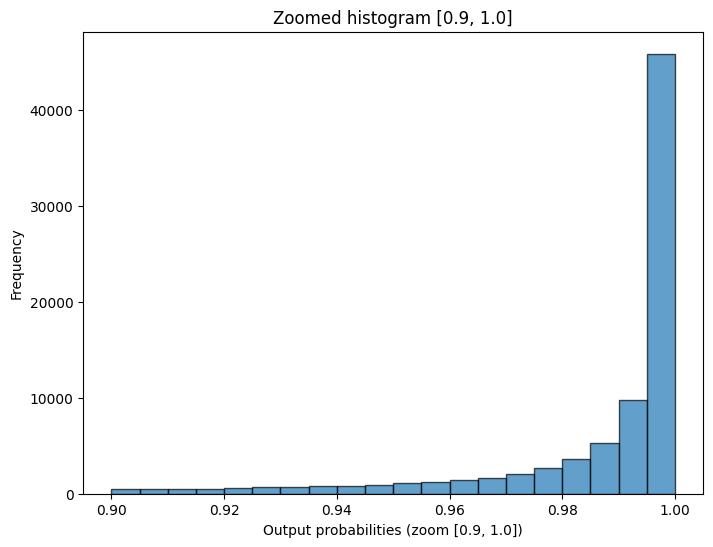

Fold 4 on 5
model filename: Best_CCS_NES_FT_N_cvfold4


Precompute Feature: 99it [00:00, 435.36it/s]
Precompute Feature: 25it [00:00, 427.44it/s]


331082
330929


Precompute Feature: 330929it [13:04, 421.79it/s]


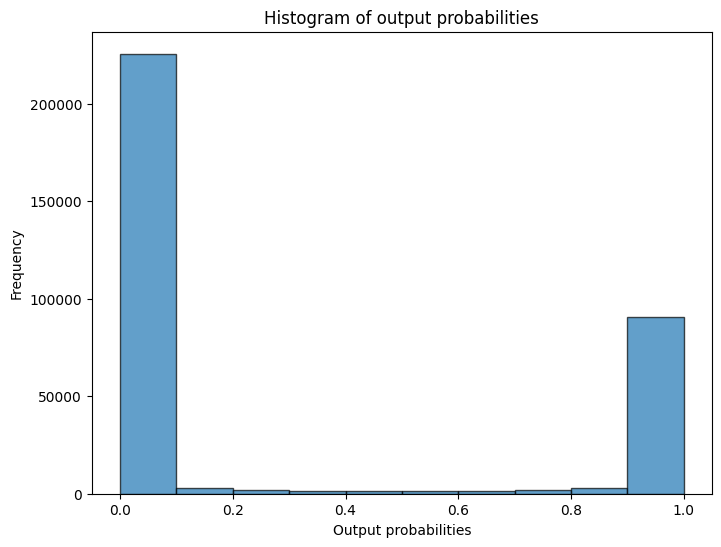

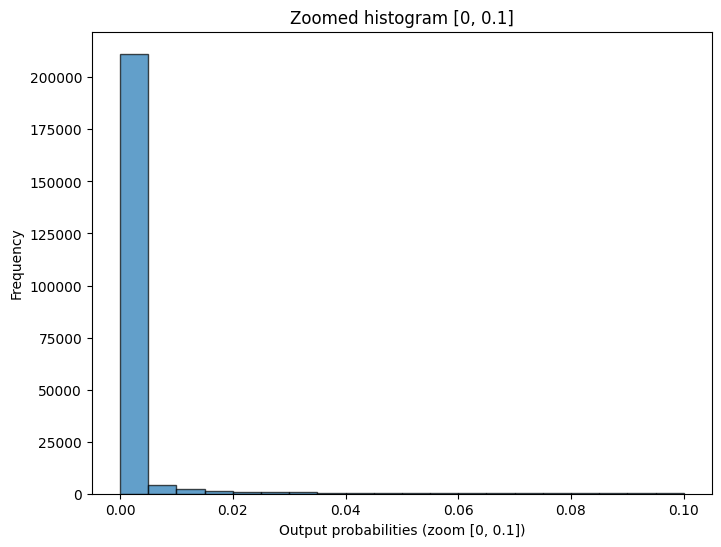

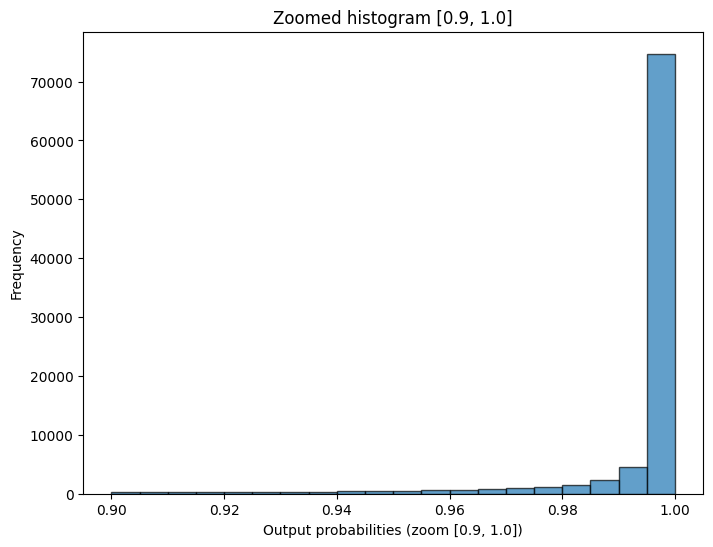

Fold 5 on 5
model filename: Best_CCS_NES_FT_N_cvfold5
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=128, embedding_size=128


Precompute Feature: 99it [00:00, 412.21it/s]
Precompute Feature: 25it [00:00, 313.30it/s]


331082
330929


Precompute Feature: 330929it [13:11, 417.91it/s]


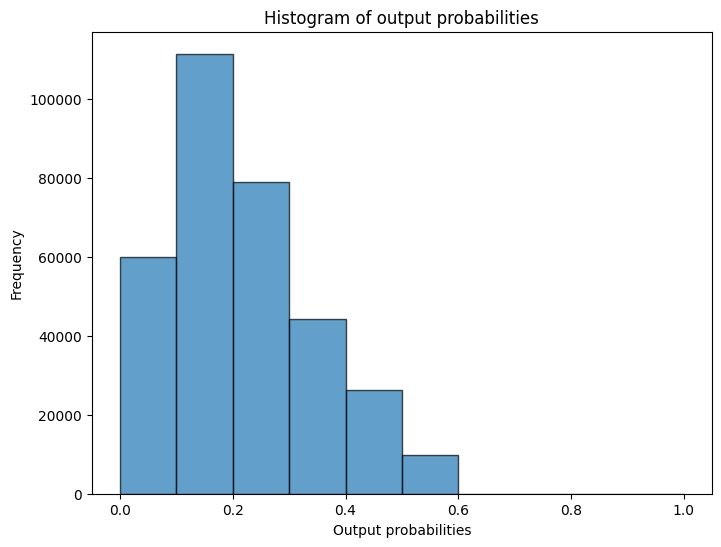

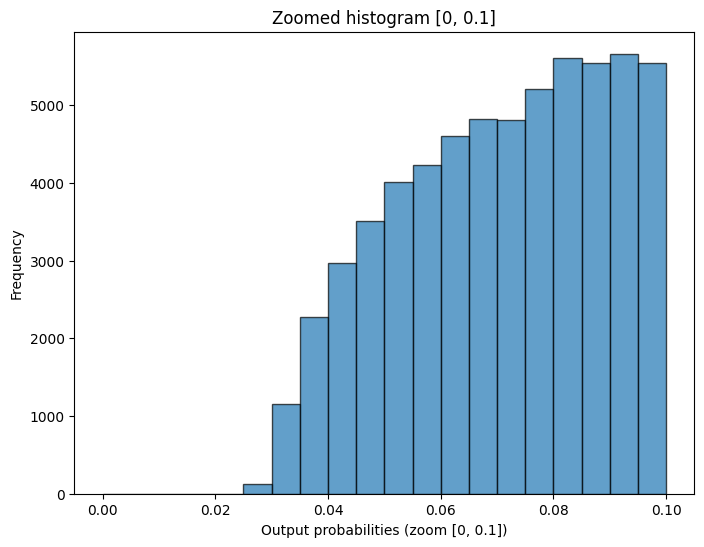

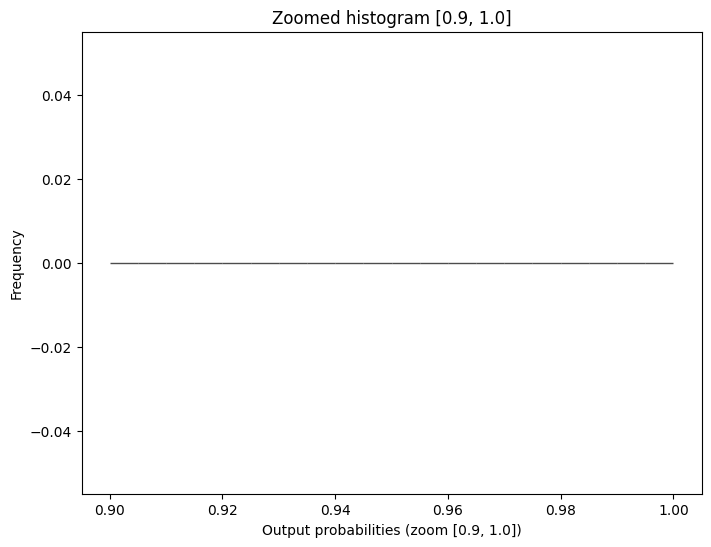

In [ ]:
LEARNING_RATE = 3e-4
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_EPOCHS = 100
N_SPLITS = 5
DROPOUT = 0.3
BATCH_SIZE = 32

# Define paths and useful variables
count = 1
do_early_stopping = False
FT = True
weighting, oversampling = (False, False)
models_path = "/content/drive/MyDrive/TFE/Models"
results_path = "/content/drive/MyDrive/TFE/Results"
images_path = "/content/drive/MyDrive/TFE/Images"

imbalanced_name_dict = {
    "Imbalance": {
        (False, False): "N",
        (True, False): "W",
        (False, True): "O"
    },
    "Early Stopping": {
        True: "ES",
        False: "NES"
    },
    "Transfer Learning": {
        True: "FT",
        False: "FE",
        None: "N"
    }
}

# The configuration of the self-training
temp_results_list = []
threshold = 0.7 # 0.5 ; 0.7 ; 0.9 ; 0.95 ; 0.99
pl_method = "optimal pr" # fixed ; TopK fixed ; TopK evo ; optimal roc ; optimal pr
percentage_evo = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fixed_percentage = 0.05 # 0.05 ; 0.01 ; 0.001
max_number_of_iterations = 5
best_thr = 0.0
hard_or_soft = "soft_loss" # hard_loss ; soft_loss

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Loop over the folds
for fold, (train_idx, test_idx) in enumerate(kf.split(df, df['quantotypic'])):
    # if fold < 4:
    #     print(f"Skipping fold {fold}")
    #     continue

    print(f"Fold {fold+1} on 5")
    evolution_list = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'pr_auc': []
    }

    pseudo_label_instance_list = []

    # Recreate the model name and extract the hyperparameters
    model_fname = f"Best_CCS_{imbalanced_name_dict['Early Stopping'][do_early_stopping]}_{imbalanced_name_dict['Transfer Learning'][FT]}_{imbalanced_name_dict['Imbalance'][(weighting, oversampling)]}_cvfold{fold+1}"
    print(f"model filename: {model_fname}")
    dropout, n_layers, hidden_size, embedding_size = find_ccs_param(f"{models_path}/FirstPart/{model_fname}.pth")

    # Load the model with the found parameters
    model_mgr = ModelManager()
    pretained_model = model_mgr.ccs_model
    model = CCSPeptideModel(pretrained_model.model.ccs_encoder, dropout_prob=dropout, num_layers=n_layers, hidden_dim=hidden_size)

    model.load_state_dict(torch.load(f"{models_path}/FirstPart/{model_fname}.pth"))

    model.to(device)

    # Split the data and create the dataloaders
    tmp_train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_df, val_df = train_test_split(tmp_train_df, test_size=0.2, stratify=tmp_train_df['quantotypic'], random_state=42)

    if oversampling:
        train_df = utils.balance_classes_with_oversampling(train_df)

    pos_weight = compute_pos_weight(train_df, 'quantotypic') if weighting else None

    train_aa_indices_list, train_mod_x_list, train_labels_list = precompute_features(train_df, pretrained_model)
    validation_aa_indices_list, validation_mod_x_list, validation_labels_list = precompute_features(val_df, pretrained_model)
    validation_dataset = CCSPeptideDataset(validation_aa_indices_list, validation_mod_x_list, validation_labels_list)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

    # Process the unlabeled data => remove the sequences that are already in the train, test, and val datasets
    unlabeled_peptide = unique_peptide

    print(len(unlabeled_peptide))
    sequences_to_remove = set(train_df["sequence"]).union(set(test_df["sequence"])).union(set(val_df["sequence"]))
    unlabeled_peptide = unlabeled_peptide[~unlabeled_peptide.isin(sequences_to_remove)]
    print(len(unlabeled_peptide))

    # Create a temporary label for the unlabeled data
    tmp_label = np.zeros(len(unlabeled_peptide))

    unlabeled_dataframe = pd.DataFrame({'sequence': unlabeled_peptide.values, 'quantotypic': tmp_label})

    unlabeled_aa_indices_list, unlabeled_mod_x_list, unlabeled_label_list = precompute_features(unlabeled_dataframe, pretrained_model)

    model_mgr = ModelManager()
    pretrained_model = model_mgr.ccs_model

    unlabeled_dataset = CCSPeptideDataset(unlabeled_aa_indices_list, unlabeled_mod_x_list, unlabeled_label_list)
    unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=False, collate_fn=collate_batch)

    outputs_probabilities = []
    for aa_idx, mod_x, y in unlabeled_dataloader:
      aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
      output = model(aa_idx, mod_x)
      outputs_probabilities.append(torch.sigmoid(output).cpu().detach().numpy())

    # Show the outputs probabilities from the model
    outputs_probabilities = np.concatenate(outputs_probabilities).flatten()
    plot_probabilities(outputs_probabilities, f"{images_path}/CCS/OutputProba/CCSOutputProbabilities_fold{fold+1}.png", zoomin=True)

# Training

In [ ]:
LEARNING_RATE = 3e-4
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_EPOCHS = 100
N_SPLITS = 5
DROPOUT = 0.3
BATCH_SIZE = 32

# Define paths and useful variables
count = 1
do_early_stopping = False
FT = True
weighting, oversampling = (False, False)
models_path = "/content/drive/MyDrive/TFE/Models"
results_path = "/content/drive/MyDrive/TFE/Results"
images_path = "/content/drive/MyDrive/TFE/Images"

imbalanced_name_dict = {
    "Imbalance": {
        (False, False): "N",
        (True, False): "W",
        (False, True): "O"
    },
    "Early Stopping": {
        True: "ES",
        False: "NES"
    },
    "Transfer Learning": {
        True: "FT",
        False: "FE",
        None: "N"
    }
}

# Configuration of the self-training
temp_results_list = []
threshold = 0.7 # 0.5 ; 0.7 ; 0.9 ; 0.95 ; 0.99
pl_method = "optimal pr" # fixed ; TopK fixed ; TopK evo ; optimal roc ; optimal pr
percentage_evo = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fixed_percentage = 0.05 # 0.05 ; 0.01 ; 0.001
max_number_of_iterations = 5
best_thr = 0.0
hard_or_soft = "soft_loss" # hard_loss ; soft_loss

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Loop over the folds
for fold, (train_idx, test_idx) in enumerate(kf.split(df, df['quantotypic'])):
    # if fold < 4:
    #     print(f"Skipping fold {fold}")
    #     continue

    print(f"Fold {fold+1} on 5")
    evolution_list = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'pr_auc': []
    }

    pseudo_label_instance_list = []

    # Recreate the model name and extract the hyperparameters
    model_fname = f"Best_CCS_{imbalanced_name_dict['Early Stopping'][do_early_stopping]}_{imbalanced_name_dict['Transfer Learning'][FT]}_{imbalanced_name_dict['Imbalance'][(weighting, oversampling)]}_cvfold{fold+1}"
    print(f"model filename: {model_fname}")
    dropout, n_layers, hidden_size, embedding_size = find_ccs_param(f"{models_path}/FirstPart/{model_fname}.pth")

    # Load the model with the found parameters
    model_mgr = ModelManager()
    pretained_model = model_mgr.ccs_model
    model = CCSPeptideModel(pretrained_model.model.ccs_encoder, dropout_prob=dropout, num_layers=n_layers, hidden_dim=hidden_size)

    model.load_state_dict(torch.load(f"{models_path}/FirstPart/{model_fname}.pth"))

    # Split the data and create the dataloaders
    tmp_train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_df, val_df = train_test_split(tmp_train_df, test_size=0.2, stratify=tmp_train_df['quantotypic'], random_state=42)

    if oversampling:
        train_df = utils.balance_classes_with_oversampling(train_df)

    pos_weight = compute_pos_weight(train_df, 'quantotypic') if weighting else None

    train_aa_indices_list, train_mod_x_list, train_labels_list = precompute_features(train_df, pretrained_model)
    validation_aa_indices_list, validation_mod_x_list, validation_labels_list = precompute_features(val_df, pretrained_model)
    validation_dataset = CCSPeptideDataset(validation_aa_indices_list, validation_mod_x_list, validation_labels_list)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

    # Evaluate the model on the test set
    results = evaluate_ccs_model(model, test_df)

    evolution_list['accuracy'].append(results['accuracy'])
    evolution_list['precision'].append(results['precision'])
    evolution_list['recall'].append(results['recall'])
    evolution_list['f1'].append(results['f1'])
    evolution_list['roc_auc'].append(results['roc_auc'])
    evolution_list['pr_auc'].append(results['pr_auc'])

    n_epoch = 20
    LR = 3e-4

    # Process the unlabeled data => remove the sequences that are already in the train, test, and val datasets
    unlabeled_peptide = unique_peptide

    print(len(unlabeled_peptide))
    sequences_to_remove = set(train_df["sequence"]).union(set(test_df["sequence"])).union(set(val_df["sequence"]))
    unlabeled_peptide = unlabeled_peptide[~unlabeled_peptide.isin(sequences_to_remove)]
    print(len(unlabeled_peptide))

    tmp_label = np.zeros(len(unlabeled_peptide))

    unlabeled_dataframe = pd.DataFrame({'sequence': unlabeled_peptide.values, 'quantotypic': tmp_label})

    unlabeled_aa_indices_list, unlabeled_mod_x_list, unlabeled_label_list = precompute_features(unlabeled_dataframe, pretrained_model)

    iter = 1

    # Start of the self-training
    while True:
        # If there are no unlabeled peptides left, break the loop
        if len(unlabeled_peptide) == 0:
            print("All unlabeled peptide have been used")
            break

        # Update the percentage for the TopK evo method
        if pl_method == "TopK evo":
            percentage = percentage_evo[iter-1]
            if percentage > 0.5:
                print("Percentage value exceed 0.5")
                break

        # Break the loop if the maximum number of iterations is reached
        if pl_method == "TopK fixed":
            percentage = fixed_percentage
            if iter > max_number_of_iterations:
                print("Max number of iterations reached")
                break

        # Find the optimal threshold for the pseudo-label generation
        if 'optimal' in pl_method:
            best_thr = find_optimal_probability_threshold(model, validation_loader, device, 'roc' if 'roc' in pl_method else 'pr', model_name='CCS')
            best_thr = round(best_thr, 3)
            print("Best threshold", best_thr)

        tmp_pl_method = pl_method.replace(" ", "_")

        # Create the filename for saving the results
        if pl_method == "fixed":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}_{threshold * 100:02.0f}"
            v = threshold
        elif pl_method == "TopK evo":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}_{percentage * 100:02.0f}"
            v = percentage
        elif pl_method == "TopK fixed":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}_{percentage * 100:02.0f}_Maxiter{max_number_of_iterations}"
            v = percentage
        elif 'optimal' in pl_method:
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}"
            v = best_thr
        print(partof_filename)

        # Load model and create dataloader
        model_mgr = ModelManager()
        pretrained_model = model_mgr.ccs_model

        unlabeled_dataset = CCSPeptideDataset(unlabeled_aa_indices_list, unlabeled_mod_x_list, unlabeled_label_list)
        unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=False, collate_fn=collate_batch)

        # Generate probabilities on unlabeled data
        outputs_probabilities = []
        for aa_idx, mod_x, y in unlabeled_dataloader:
          aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
          output = model(aa_idx, mod_x)
          outputs_probabilities.append(torch.sigmoid(output).cpu().detach().numpy())

        outputs_probabilities = np.concatenate(outputs_probabilities).flatten()
        plot_probabilities(outputs_probabilities, f"{images_path}/CCS/CCSOutputProbabilities_iter{iter}_{partof_filename}.png")

        # Generate pseudo-labels based on probabilities
        class1, class0 = generate_pseudo_labels(outputs_probabilities, method=pl_method, value=v)
        train_df = train_df.drop_duplicates(subset="sequence", keep="first")
        class1_sum, class0_sum = class1.sum(), class0.sum()

        print(f"class1 = {class1_sum} ; class0 = {class0_sum} ; len(train_df) = {len(train_df)}")

        pseudo_label_instance_list.append((class0_sum, class1_sum))

        # If too few pseudo-labels are generated, break the loop
        if (pl_method == "fixed" or 'optimal' in pl_method) and class1_sum + class0_sum < 0.01 * len(train_df):
          print("No new pseudo label can be generated")
          break

        # Delete the pseudo-labeled peptides from the unlabeled dataset
        new_nonquanto = unlabeled_peptide[class1]
        new_quanto = unlabeled_peptide[class0]
        print(f"new non quanto {len(new_nonquanto)}")
        print(f"new quanto {len(new_quanto)}")

        delete_pseudo_labeled_peptide = class1 | class0

        unlabeled_peptide = unlabeled_peptide[~delete_pseudo_labeled_peptide]
        unlabeled_aa_indices_list = [unlabeled_aa_indices_list[i] for i in range(len(unlabeled_aa_indices_list)) if not delete_pseudo_labeled_peptide[i]]
        unlabeled_mod_x_list = [unlabeled_mod_x_list[i] for i in range(len(unlabeled_mod_x_list)) if not delete_pseudo_labeled_peptide[i]]
        unlabeled_label_list = [unlabeled_label_list[i] for i in range(len(unlabeled_label_list)) if not delete_pseudo_labeled_peptide[i]]
        print(f"{len(unlabeled_peptide)} unlabeled peptides remaining")

        # Create a new dataframe with the pseudo-labeled peptides
        if hard_or_soft == "hard_loss":
            new_nonquanto = pd.DataFrame({"sequence": new_nonquanto, "quantotypic": 1})
            new_quanto = pd.DataFrame({"sequence": new_quanto, "quantotypic": 0})
        else:
            print("soft_loss")
            new_nonquanto = pd.DataFrame({"sequence": new_nonquanto, "quantotypic": outputs_probabilities[class1]})
            new_quanto = pd.DataFrame({"sequence": new_quanto, "quantotypic": outputs_probabilities[class0]})

        # Update the training set
        train_df = pd.concat([train_df, new_nonquanto, new_quanto], ignore_index=True)

        # Recompute the features for the new data and add it to the training set
        new_nonquanto_aa_indices_list, new_nonquanto_mod_x_list, new_nonquanto_label_list = precompute_features(new_nonquanto, pretrained_model)
        new_quanto_aa_indices_list, new_quanto_mod_x_list, new_quanto_label_list = precompute_features(new_quanto, pretrained_model)

        train_aa_indices_list.extend(new_nonquanto_aa_indices_list)
        train_mod_x_list.extend(new_nonquanto_mod_x_list)
        train_labels_list.extend(new_nonquanto_label_list)

        train_aa_indices_list.extend(new_quanto_aa_indices_list)
        train_mod_x_list.extend(new_quanto_mod_x_list)
        train_labels_list.extend(new_quanto_label_list)

        print(f"After concat: {len(train_df)}")

        if oversampling:
            train_df = utils.balance_classes_with_oversampling(train_df, loss_type = "hard" if hard_or_soft == "hard_loss" else "soft")

        pos_weight = compute_pos_weight(train_df, 'quantotypic') if weighting else None

        # Recreate the dataloader with the new training set
        train_dataset = CCSPeptideDataset(train_aa_indices_list, train_mod_x_list, train_labels_list)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

        # Retrain the model with the new training set
        print(f"Retraining the model....")
        history = train(model, train_loader, validation_loader, n_epoch, LR, do_early_stopping=do_early_stopping,
                                            model_name='CCS', weight=pos_weight, verbose=True)

        # Evaluate the model on the test set
        results = evaluate_ccs_model(model, test_df)

        evolution_list['accuracy'].append(results['accuracy'])
        evolution_list['precision'].append(results['precision'])
        evolution_list['recall'].append(results['recall'])
        evolution_list['f1'].append(results['f1'])
        evolution_list['roc_auc'].append(results['roc_auc'])
        evolution_list['pr_auc'].append(results['pr_auc'])

        wandb.init(project="CCS", name=f"SelfTraining_CCS_cvfold{fold+1}_iter{iter}",
                    config={
                        "weighting": weighting,
                        "oversampling": oversampling,
                        "early_stopping": do_early_stopping,
                        "method" : pl_method,
                        "Threshold": threshold if 'fixed' in pl_method else best_thr,
                        "Percentage": percentage if pl_method == "TopK fixed" else None,
                        "n_epoch": n_epoch,
                        "LR": LR,
                        "Max iter": max_number_of_iterations,
                        "Hard or soft": hard_or_soft
                    })

        wandb.log(results)
        wandb.finish()

        iter += 1

    torch.save(model.state_dict(), f"{models_path}/SelfTraining/CCS/SelfTraining_CCS_{partof_filename}.pth")

    self_training_results = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1'],
        'roc_auc': results['roc_auc'],
        'pr_auc': results['pr_auc']
    }

    temp_results_list.append(self_training_results)

    write_into_json(evolution_list, f"{results_path}/SelfTraining/CCS/SelfTraining_CCS_Evolution_{partof_filename}.json")
    write_into_json(self_training_results, f"{results_path}/SelfTraining/CCS/SelfTraining_CCS_Results_{partof_filename}.json")

    plot_pl_instances(pseudo_label_instance_list, f"{images_path}/CCS/PseudoLabelInstances_{partof_filename}")

accuracy_list = [res['accuracy'] for res in temp_results_list]
precision_list = [res['precision'] for res in temp_results_list]
recall_list = [res['recall'] for res in temp_results_list]
f1_list = [res['f1'] for res in temp_results_list]
roc_auc_list = [res['roc_auc'] for res in temp_results_list]
pr_auc_list = [res['pr_auc'] for res in temp_results_list]

metrics_summary = {
    'accuracy_mean': np.mean(accuracy_list),
    'accuracy_std': np.std(accuracy_list),
    'precision_mean': np.mean(precision_list),
    'precision_std': np.std(precision_list),
    'recall_mean': np.mean(recall_list),
    'recall_std': np.std(recall_list),
    'f1_mean': np.mean(f1_list),
    'f1_std': np.std(f1_list),
    'roc_auc_mean': np.mean(roc_auc_list),
    'roc_auc_std': np.std(roc_auc_list),
    'pr_auc_mean': np.mean(pr_auc_list),
    'pr_auc_std': np.std(pr_auc_list),
}

wandb.init(project="CCS", name=f"SelfTraining_CCS_Summary",
        config={
                "weighting": weighting,
                "oversampling": oversampling,
                "early_stopping": do_early_stopping,
                "method" : pl_method,
                "Threshold": threshold if 'fixed' in pl_method else best_thr,
                "Percentage": percentage if pl_method == "TopK fixed" else None,
                "n_epoch": n_epoch,
                "LR": LR,
                "Max iter": max_number_of_iterations,
                "Hard or soft": hard_or_soft
            })

wandb.log(metrics_summary)
wandb.finish()

dict_save = {
    'weighting': weighting,
    'oversampling': oversampling,
    'early_stopping': do_early_stopping,
    'method': pl_method,
    "Threshold": threshold if 'fixed' in pl_method else best_thr,
    "Hard or soft": hard_or_soft,
    'metrics': metrics_summary
}

if pl_method == "fixed":
    final_filename = f"{tmp_pl_method}_{threshold * 100:02.0f}"
elif "TopK" in pl_method:
    final_filename = f"{tmp_pl_method}_{percentage * 100:02.0f}"
else:
    final_filename = f"{tmp_pl_method}"

write_into_json(dict_save, f"{results_path}/SelfTraining/CCS/SelfTraining_CCS_CVSummary_{final_filename}.json")

Skipping fold 0
Skipping fold 1
Skipping fold 2
Skipping fold 3
Fold 5 on 5
model filename: Best_CCS_NES_FT_N_cvfold5
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=64, embedding_size=64
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=128, embedding_size=128


Precompute Feature: 99it [00:00, 450.62it/s]
Precompute Feature: 25it [00:00, 472.82it/s]
Precompute Feature: 31it [00:00, 373.10it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


331082
330929


Precompute Feature: 330929it [12:35, 438.20it/s]


pr
Best threshold 0.728
cvfold5_optimal_pr_soft_loss
class1 = 0 ; class0 = 281015 ; len(train_df) = 99
new non quanto 0
new quanto 281015
49914 unlabeled peptides remaining
soft_loss


Precompute Feature: 0it [00:00, ?it/s]
Precompute Feature: 281015it [10:41, 437.92it/s]


After concat: 281114
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


Precompute Feature: 31it [00:00, 479.21it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jimmy-walraff02 (TFE-proteomics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.74194
f1,0
pr_auc,0.28734
precision,0
recall,0


pr
Best threshold 0.5
cvfold5_optimal_pr_soft_loss
class1 = 0 ; class0 = 49914 ; len(train_df) = 281114
new non quanto 0
new quanto 49914
0 unlabeled peptides remaining
soft_loss


Precompute Feature: 0it [00:00, ?it/s]
Precompute Feature: 49914it [01:55, 433.34it/s]


After concat: 331028
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


Precompute Feature: 31it [00:00, 454.04it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.74194
f1,0
pr_auc,0.33299
precision,0
recall,0


All unlabeled peptide have been used


accuracy_mean,▁
accuracy_std,▁
f1_mean,▁
f1_std,▁
pr_auc_mean,▁
pr_auc_std,▁
precision_mean,▁
precision_std,▁
recall_mean,▁
recall_std,▁
roc_auc_mean,▁


In [ ]:
print(pretrained_model.model.ccs_encoder)

Encoder_26AA_Mod_Charge_CNN_LSTM_AttnSum(
  (mod_nn): Mod_Embedding_FixFirstK(
    (nn): Linear(in_features=103, out_features=2, bias=False)
  )
  (input_cnn): SeqCNN(
    (cnn_short): Conv1d(36, 36, kernel_size=(3,), stride=(1,), padding=(1,))
    (cnn_medium): Conv1d(36, 36, kernel_size=(5,), stride=(1,), padding=(2,))
    (cnn_long): Conv1d(36, 36, kernel_size=(7,), stride=(1,), padding=(3,))
  )
  (hidden_nn): SeqLSTM(
    (rnn): LSTM(144, 128, num_layers=2, batch_first=True, bidirectional=True)
  )
  (attn_sum): SeqAttentionSum(
    (attn): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=False)
      (1): Softmax(dim=1)
    )
  )
)


In [ ]:
dir(pretrained_model.model.ccs_encoder)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_se

In [ ]:
print(pretrained_model.model)

Model_CCS_LSTM(
  (dropout): Dropout(p=0.1, inplace=False)
  (ccs_encoder): Encoder_26AA_Mod_Charge_CNN_LSTM_AttnSum(
    (mod_nn): Mod_Embedding_FixFirstK(
      (nn): Linear(in_features=103, out_features=2, bias=False)
    )
    (input_cnn): SeqCNN(
      (cnn_short): Conv1d(36, 36, kernel_size=(3,), stride=(1,), padding=(1,))
      (cnn_medium): Conv1d(36, 36, kernel_size=(5,), stride=(1,), padding=(2,))
      (cnn_long): Conv1d(36, 36, kernel_size=(7,), stride=(1,), padding=(3,))
    )
    (hidden_nn): SeqLSTM(
      (rnn): LSTM(144, 128, num_layers=2, batch_first=True, bidirectional=True)
    )
    (attn_sum): SeqAttentionSum(
      (attn): Sequential(
        (0): Linear(in_features=256, out_features=1, bias=False)
        (1): Softmax(dim=1)
      )
    )
  )
  (ccs_decoder): Decoder_Linear(
    (nn): Sequential(
      (0): Linear(in_features=257, out_features=64, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )

In [ ]:
dir(pretrained_model)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_as_tensor',
 '_check_predict_in_order',
 '_device',
 '_device_ids',
 '_device_type',
 '_fixed_sequence_len',
 '_get_26aa_indice_features',
 '_get_aa_features',
 '_get_aa_indice_features',
 '_get_aa_indice_features_padding_zeros',
 '_get_aa_mod_features',
 '_get_features_from_batch_df',
 '_get_lr_schedule_with_warmup',
 '_get_mod_features',
 '_get_targets_from_batch_df',
 '_init_for_training',
 '_load_model_from_pytorchfile',
 '_load_model_from_stream',
 '_load_model_from_zipfile',
 '_min_pred_value',
 '_model_to_device',
 '_pad_zeros_if_fixed_len',
 '_predict_one_batch',
 '_prepare_predict_data_df',
 '_prepare_train_dat